# 1.Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np

# 2. Loading and preparation of data
As a basis for comparison we will be using the MNIST dataset. If we manage to do all the work we want, we will then use other datasets for comparison.

### 2.1. Definition of methods to extract data and labels

In [2]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

### 2.2. Load data

In [3]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000
data_folder = 'mnist_data'

train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

### 2.3. Convert data from numpy arrays to torch tensors

In [4]:
features_train=torch.from_numpy(train_images)
features_test=torch.from_numpy(test_images)
print('Training features:', features_train.shape, '\n'
'Testing features:', features_test.shape)

labels_train=torch.from_numpy(train_labels)
labels_test=torch.from_numpy(test_labels)
print('Training labels:', labels_train.shape, '\n'
'Testing labels:', labels_test.shape)

Training features: torch.Size([60000, 28, 28]) 
Testing features: torch.Size([10000, 28, 28])
Training labels: torch.Size([60000]) 
Testing labels: torch.Size([10000])


### 2.4. Normalize data

In [5]:
mean, std = features_train.float().mean(), features_train.float().std()

features_train = features_train.float().sub_(mean).div_(std)
features_test = features_test.float().sub_(mean).div_(std)

# 3. Setting up network and evaluation methods

### 3.1. Multilayer perceptron (MLP)

##### 3.1.1. Defining class

In [6]:
class MLP(nn.Module):
    
    def __init__(self, hidden_size_1=512, hidden_size_2=100, hidden_size_3=10):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size_1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2))
            # nn.ReLU(inplace=True),
            # nn.Linear(hidden_size_2, hidden_size_3)) #maybe try more layers
    
    # forward pass
    def forward(self, x):
        return self.layers(x)

mlp = MLP()

##### 3.1.2. Implementation of method for training

In [7]:
def mlp_nn(x_train, y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch):
    loss_all_train, loss_all_test = [], []
    epochs_all = torch.arange(1, num_epoch+num_epoch/10, num_epoch/10)
    epochs_all[-1] = num_epoch - 1
            
    for epoch in range(num_epoch):
        for b in range(0, x_train.size(0), size_minibatch):
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()
        
        if epoch % 20 == 0:
            loss_train = loss_train.detach().numpy()
            loss_all_train.append(loss_train)

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            loss_test = loss_test.detach().numpy()
            loss_all_test.append(loss_test)
            acc = accuracy(y_test_obt, y_test)
            
            print ('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f, Accuracy: %.4f' 
            %(epoch+1, num_epoch, loss_train, loss_test, acc))

        if epoch == num_epoch - 1:
            loss_train = loss_train.detach().numpy()
            loss_all_train.append(loss_train)

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            loss_test = loss_test.detach().numpy()
            loss_all_test.append(loss_test)
            acc = accuracy(y_test_obt, y_test)
            
            print('Final, Train Loss: %.4f, Test Loss: %.4f, Accuracy: %.4f' %(loss_train, loss_test, acc))

            # plotting train and test loss

            fig, axs = plt.subplots(1, 2, figsize=(10, 8))
            axs[0].plot(epochs_all, loss_all_train, linewidth=2.5, color='blue')
            axs[0].set_ylabel('Train Loss', fontsize=12)
            axs[0].set_xlabel('Epoch', fontsize=12)

            axs[1].plot(epochs_all, loss_all_test, linewidth=2.5, color='orange')
            axs[1].set_ylabel('Test Loss', fontsize=12)
            axs[1].set_xlabel('Epoch', fontsize=12)
            fig.suptitle('MLP Convergence', fontsize=15)
            plt.show()

    return loss_all_train, loss_all_test

### 3.2. Metrics
We have chosen to look at accuracy to evaluate the performance of our optimizers

In [8]:
def accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

# 4. Simple training
For the sake of experimentation, we have used the parameters from the paper, which were the ones found to be the best for this specific optimizer

### 4.1. Setting up training parameters

In [9]:
model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200 
size_minibatch = 128
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

### 4.2. Training

Epoch [1/200], Train Loss: 0.2776, Test Loss: 0.1594, Accuracy: 0.9484
Epoch [21/200], Train Loss: 0.0538, Test Loss: 0.1171, Accuracy: 0.9784
Epoch [41/200], Train Loss: 0.0000, Test Loss: 0.1693, Accuracy: 0.9775
Epoch [61/200], Train Loss: 0.0021, Test Loss: 0.1954, Accuracy: 0.9787
Epoch [81/200], Train Loss: 0.0000, Test Loss: 0.2023, Accuracy: 0.9806
Epoch [101/200], Train Loss: 0.0000, Test Loss: 0.2037, Accuracy: 0.9821
Epoch [121/200], Train Loss: 0.0000, Test Loss: 0.2620, Accuracy: 0.9803
Epoch [141/200], Train Loss: 0.0000, Test Loss: 0.2434, Accuracy: 0.9834
Epoch [161/200], Train Loss: 0.0000, Test Loss: 0.2676, Accuracy: 0.9836
Epoch [181/200], Train Loss: 0.0000, Test Loss: 0.2617, Accuracy: 0.9841
Final, Train Loss: 0.0000, Test Loss: 0.2581, Accuracy: 0.9845


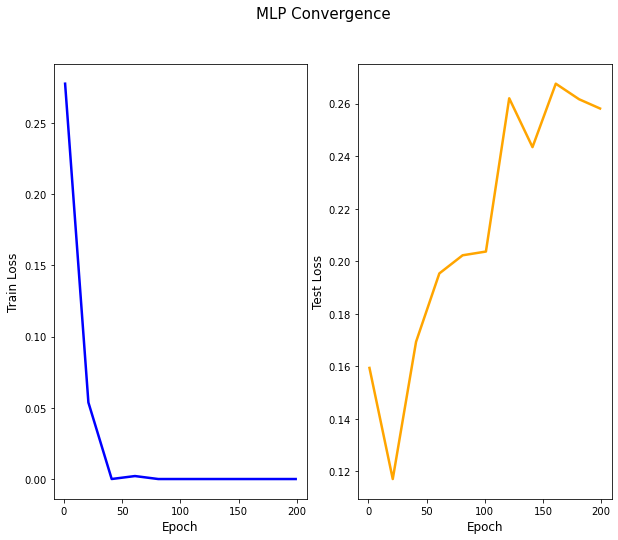

In [ ]:
loss_all_train, loss_all_test = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)

# 5. Cross validation training
At this stage, we want to select the hyperparameter search space for each optimizer. This way, we can first tune the hyperparameters of each optimizer separately and then select the trial that achieved lowest final validation error.
We then comapre the optimizers' performance by looking at the validation and test errors as suggested in the paper "On empirical comparisons of optimizers for deep learning".

We will also look at the training speed (number of training steps required) to reach a traget validation error.

Everything is tuned on a log scale.

No L_2 regularization or weight decay is used.

### 5.1. Tuning protocol using bootstrap
To tune the hyperparamters we will use bootstrapping starting from an initial search space suggested by the paper "On Empirical Comparisons of Optimizers for Deep Learning".
We run N trials by randomly picking values in the search space of the algorithm at every trial.
Then we sample these trials with replacement and compute our statistic on the first K trials of this sample. We repeat this process 100 times and compute the 5th percentile and 95th percentile of the bootstrap distribution.

This allows us to plot the error bars to show the results.

### 5.2. Tuning Adam for a CNN on MNIST
The hyperparameters we are tuning are alpha_0/epsilon, 1 - beta_1, 1 - beta_2, epsilon.
The initial search spaces are suggested based on the experience of the writers of the same paper, "On empirical comparisons of optimizers for deep learning".
N is also suggested to be 500 and K to be 100.

##### 5.2.1. Set up parameters and search space

In [ ]:
# TODO: We used the final search spaces instead of the initial ones, should we reproduce the whole method

N = 500 # Number of trials
K = 100 # Number of trials being kept for the statistic
epochs = 50 # Number of training steps

alpha_0 = np.logspace(10**(-1), 10, N)
beta_1 = np.logspace(10**(-3), 1, N)
beta_2 = np.logspace(10**(-4), 1, N)
beta_1 = np.logspace(10**(-6), 10**(-2), N)

##### 5.2.2. Set up model

In [ ]:
model = MLP()
criterion = nn.CrossEntropyLoss() # good loss function for classification tasks
num_epoch = 200 
size_minibatch = 128
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # weight_decay is an L2 regularisation to avoid overfitting

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### 5.2.2. Run bootstrapping

In [ ]:
N_trials = []
for _ in range(N):
    # TODO: sample values here
    train_error, test_error = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)